作者: 阿凯爱玩机器人 | 微信: xingshunkai  | QQ: 244561792

[B站](https://space.bilibili.com/40344504) | [淘宝店铺](https://shop140985627.taobao.com) | [购买链接](https://item.taobao.com/item.htm?id=677075846402)
## 导入依赖

In [1]:
import os
import time
import numpy as np
import cv2
from matplotlib import pyplot as plt
# 阿凯机器人工具箱
from kyle_robot_toolbox.camera import Gemini335
from kyle_robot_toolbox.yolov8 import YoloV8Detect

pybullet build time: May 20 2022 19:44:17


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%matplotlib inline

## 相机初始化

In [3]:
# 创建相机对象
camera = Gemini335()

[I20230503 14:41:03.565608 42091 Context.cpp:13] Context creating!
[I20230503 14:41:03.565879 42091 Context.cpp:78] filter version[major.minor.maintenance.build]: 1.1.4.0
[I20230503 14:41:03.565914 42091 DeviceManager.cpp:54] DeviceManager init ...
[I20230503 14:41:03.566041 42091 LinuxPal.cpp:21] createObPal: create LinuxPal!
[I20230503 14:41:03.851845 42091 EnumeratorLibusb.cpp:325] queryDevicesInfo done!
[I20230503 14:41:03.852208 42091 DeviceManager.cpp:373] Current usb device port list::
[I20230503 14:41:03.852217 42091 DeviceManager.cpp:375]         - 2-5.4.1-6.0 | Orbbec Gemini 2 Depth Camera
[I20230503 14:41:03.852222 42091 DeviceManager.cpp:375]         - 2-5.4.1-6.2 | Orbbec Gemini 2 IR Camera
[I20230503 14:41:03.852226 42091 DeviceManager.cpp:375]         - 2-5.4.1-6.4 | Orbbec Gemini 2 RGB Camera
[I20230503 14:41:03.852231 42091 DeviceManager.cpp:375]         - 2-5.4.1-6.6 | Orbbec Gemini Data Channel
[I20230503 14:41:03.852236 42091 DeviceManager.cpp:375]         - 2-5.4.1

## YoloV8模型初始化

In [4]:
# 模型路径
model_path = os.path.join(os.path.abspath("."), "weights", "bottle_cap_yolov8n.pt")
print(model_path)

/home/kyle/Project/奥比中光3D相机/deepsense-gemini2/03.Gemini-3D相机案例源码/yolov8-example/weights/bottle_cap_yolov8n.pt


In [5]:
# 加载模型
print("[INFO] 开始YoloV8模型加载")
# 载入目标检测模型(使用绝对路径)
model = YoloV8Detect(model_path)

# 配置模型参数(可选)
# - 图像尺寸(必须是32的倍数)
model.IMAGE_SIZE= 1088
# - 置信度
model.CONFIDENCE = 0.7
# - IOU 
model.IOU = 0.6
print("[INFO] 完成YoloV8模型加载")

[INFO] 开始YoloV8模型加载
[INFO] 完成YoloV8模型加载


## 采集图像

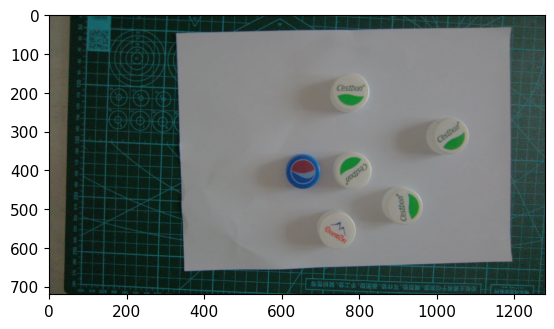

In [6]:
# 采集彩图与深度图, 单位为mm
img_bgr, depth_img = camera.read() 
# 图像可视化
plt.imshow(img_bgr[:, :, ::-1])

In [7]:
cv2.imwrite("img_bgr.png", img_bgr)

True

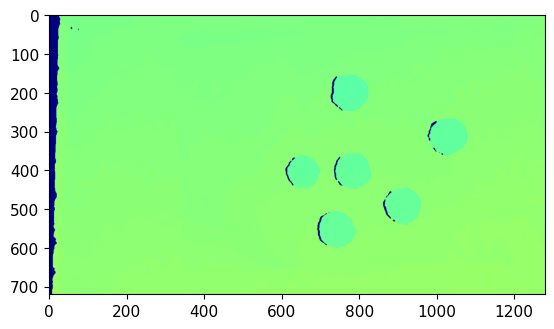

In [8]:
# 将深度转换为可视化画布
# 根据实际情况调整深度范围 [min_distance, max_distance]
depth_canvas_tmp = camera.depth_img2canvas(depth_img)
# 为了兼容Gemini深度图与彩图尺寸不一致的情况
# 要做一下特殊处理
dp_h, dp_w, dp_ch = depth_canvas_tmp.shape
depth_canvas = np.zeros_like(img_bgr)
depth_canvas[:dp_h, :dp_w] = depth_canvas_tmp

plt.imshow(depth_canvas[:, :, ::-1])
plt.imshow(depth_canvas[:, :, ::-1])

In [9]:
cv2.imwrite("depth_canvas.png", depth_canvas)

True

## YoloV5目标检测

In [10]:
# YoloV5 目标检测
canvas, class_id_list, xyxy_list, conf_list = model.detect(img_bgr, \
                                                           draw_label=False)


0: 640x1088 6 bottle_caps, 24.9ms
Speed: 4.3ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1088, 1088)


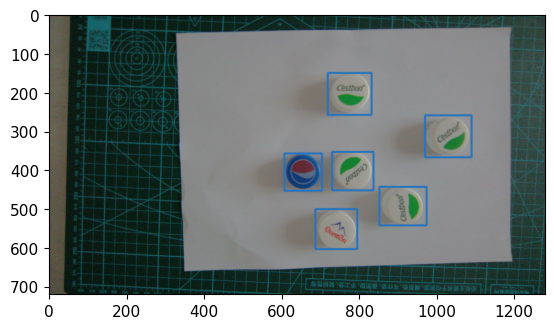

In [11]:
# 展示画布
plt.imshow(canvas[:, :, ::-1])

In [12]:
cv2.imwrite("canvas.png", canvas)

True

## 绘制物体中心点

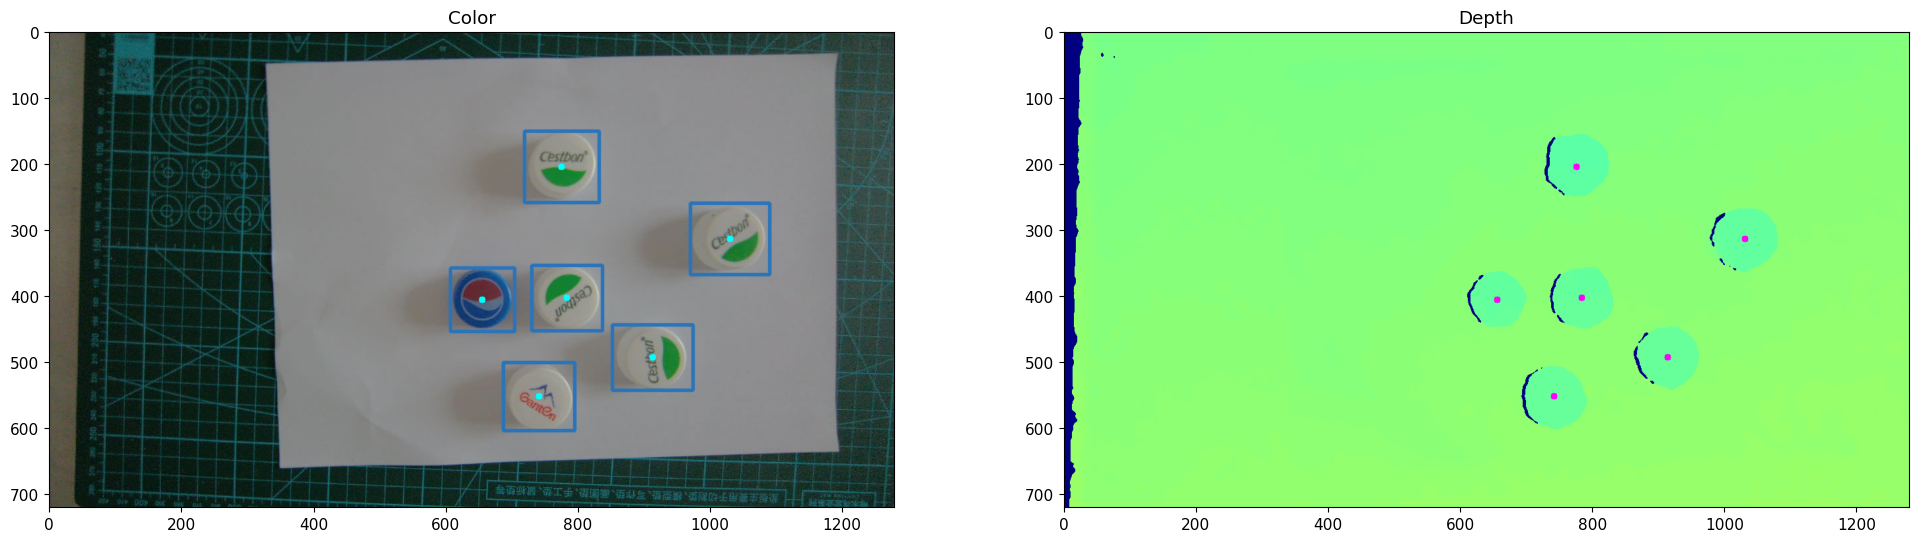

In [13]:
# canvas = np.copy(img_bgr)
center_list = []

for xyxy in xyxy_list:
    # 读取矩形框
    x1, y1, x2, y2 = xyxy
    # 计算中心点
    cx = int((x1 + x2)/2)
    cy = int((y1 + y2)/2)
    # 绘制中心点
    cv2.circle(canvas, [cx, cy], 5, (255, 255, 0), -1)
    cv2.circle(depth_canvas, [cx, cy], 5, (255, 0, 255), -1)
    center_list.append([cx, cy])
    
plt.figure(figsize=(24, 16))
plt.subplot(1, 2, 1)
plt.title("Color")
plt.imshow(canvas[:, :, ::-1])

plt.subplot(1, 2, 2)
plt.title("Depth")
plt.imshow(depth_canvas[:, :, ::-1])

plt.savefig("color_and_depth.png")

## 获取物体中心点的三维坐标

深度值: 227.0000033825636 mm
彩色相机坐标系下的坐标: [44.7, -51.0, 227.0], 单位mm
深度值: 230.2000034302473 mm
彩色相机坐标系下的坐标: [91.3, 44.3, 230.2], 单位mm
深度值: 230.2000034302473 mm
彩色相机坐标系下的坐标: [34.0, 64.0, 230.2], 单位mm
深度值: 229.20000341534615 mm
彩色相机坐标系下的坐标: [5.3, 15.2, 229.2], 单位mm
深度值: 229.40000341832638 mm
彩色相机坐标系下的坐标: [47.8, 14.2, 229.4], 单位mm
深度值: 229.0000034123659 mm
彩色相机坐标系下的坐标: [129.6, -15.3, 229.0], 单位mm


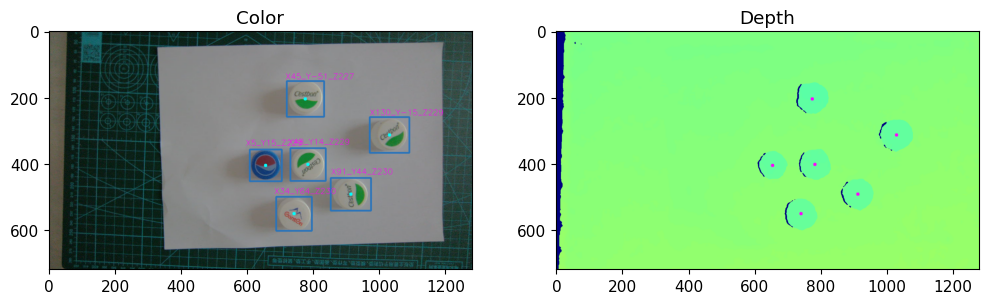

In [14]:
for center in center_list:
    px, py = center
    # 读取深度值
    depth_value = depth_img[py, px]
    print(f"深度值: {depth_value} mm")
    # 判断坐标是否在深度图的有效范围内
    if px >= dp_w or py >= dp_h:
        continue 
    # 读取深度值
    depth_value = depth_img[py, px]
    # 深度值无效
    if depth_value == 0:
        continue
            
    cam_point3d = camera.depth_pixel2cam_point3d(\
                                    px, py, depth_value=depth_value)
    # 计算三维坐标
    cam_x, cam_y, cam_z = cam_point3d
    print(f"彩色相机坐标系下的坐标: [{cam_x:.1f}, {cam_y:.1f}, {cam_z:.1f}], 单位mm")
    # 在画面上绘制坐标
    tag = f"X{cam_x:.0f}_Y{cam_y:.0f}_Z{cam_z:.0f}"
    cv2.putText(canvas, text=tag,\
        org=(px-60, py-60), fontFace=cv2.FONT_HERSHEY_SIMPLEX, \
        fontScale=0.8, thickness=1, lineType=cv2.LINE_AA, color=(255, 0, 255))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Color")
plt.imshow(canvas[:, :, ::-1])

plt.subplot(1, 2, 2)
plt.title("Depth")
plt.imshow(depth_canvas[:, :, ::-1])

plt.savefig("color_and_depth2.png")